In [1]:
import sys
sys.path.append('../src/')

from adaline import Adaline
from data_loader import DataLoader
from model import Model
from operator import and_, or_, xor
from random_fns import RandomFunction, Uniform
from simple_perceptron import SimplePerceptron
from trainer import Trainer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_dataloader(fn, logic='bipolar') -> DataLoader:
    if logic == 'bipolar':
        f = lambda x: 1.0 if x else -1.0
    elif logic == 'unipolar':
        f = lambda x: 1.0 if x else 0.0
    else:
        raise ValueError(f"'{logic}' is not a valid logic type")
    data = [(np.array([[f(a), f(b)]]), np.array([[f(fn(a, b))]]))
            for a in [False, True] for b in [False, True]]

    return DataLoader(data)

In [3]:
def sample(perform: callable, n: float):
    total = 0
    samples = 0
    for sample in range(n):
        epochs = perform()
        if not np.isinf(epochs):
            total += epochs
            samples += 1
        
    return total / samples if samples > 0 else np.inf

# Simple perceptron

## Experiment #1

The aim of this experiment is to perform model trainings with different threshold values θ for small initial values of the weights, observing the number of epochs needed to train the model.

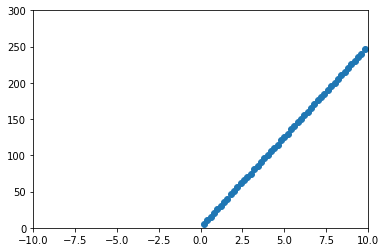

In [4]:
dataloader = generate_dataloader(and_)
random_fn = Uniform(-0.1, 0.1)


def factory(θ: float):
    def perform():
        model = SimplePerceptron(
            input_size=2,
            random_fn=random_fn,
            threshold=θ,
            learning_rate=0.01,
        )
        trainer = Trainer(max_epochs=1000)
        epochs = trainer.fit(model, dataloader)

        return epochs if epochs < 1000 else np.inf
        
    return perform


results = [(θ, sample(factory(θ), n=10)) for θ in np.arange(-10.0, 10.0, 0.2)]

x, y = zip(*results)
plt.plot(x, y, 'o')
plt.axis([-10.0, 10.0, 0, 300])
plt.show()

## Experiment #2

The aim of this experiment is to determine if and how the range of the initial weight values affects the training speed i.e. the number of epochs needed to train the model, and possibly to find the optimal value at which the model learns the fastest.

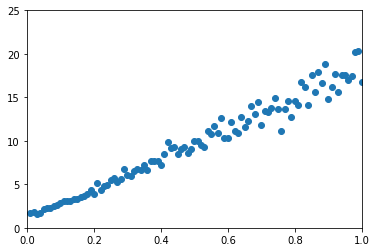

In [5]:
dataloader = generate_dataloader(and_)


def factory(d: float):
    def perform():
        model = SimplePerceptron(
            input_size=2,
            random_fn=Uniform(-d, d),
            learning_rate=0.01,
        )
        trainer = Trainer()
        epochs = trainer.fit(model, dataloader)

        return epochs

    return perform


results = [(d, sample(factory(d), n=50)) for d in np.arange(1.0, 0.0, -0.01)]

x, y = zip(*results)
plt.plot(x, y, 'o')
plt.axis([0.0, 1.0, 0, 25])
plt.show()

## Experiment #3

The aim of this experiment is to determine the effect of the learning rate α on the training speed of the model.

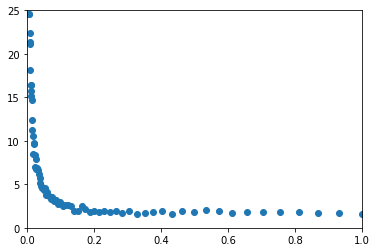

In [6]:
dataloader = generate_dataloader(and_)
random_fn = Uniform(-1.0, 1.0)


def factory(α: float):
    def perform():
        model = SimplePerceptron(
            input_size=2,
            random_fn=random_fn,
            learning_rate=α,
        )
        trainer = Trainer()
        epochs = trainer.fit(model, dataloader)

        return epochs

    return perform


results = [(α, sample(factory(α), n=50)) for α in np.logspace(-3.0, 0.0, num=100)]

x, y = zip(*results)
plt.plot(x, y, 'o')
plt.axis([0.0, 1.0, 0, 25])
plt.show()

## Experiment #4

The aim of this experiment is to apply both the unipolar and the bipolar activation functions on the model and check their effect on the learning speed of the model.

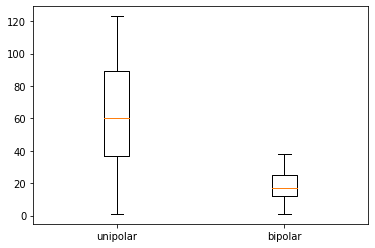

In [7]:
random_fn = Uniform(-1.0, 1.0)


def factory(logic: str):
    dataloader = generate_dataloader(and_, logic=logic)

    def perform():
        model = SimplePerceptron(
            input_size=2,
            random_fn=random_fn,
            learning_rate=0.01,
            logic=logic
        )
        trainer = Trainer()
        epochs = trainer.fit(model, dataloader)

        return epochs
        
    return perform


results = {logic: [factory(logic)() for _ in range(100)] for logic in ['unipolar', 'bipolar']}

fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())
plt.show()